## Constraint softening

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from openmpc.models import LinearSystem
from openmpc.mpc import MPCParameters, MPC



In [2]:

# Define the discrete-time state-space model
A = np.array([[0.8, -0.6, 0.2],
              [1, 0, 0],
              [0, 0.8, 0.6]])
B = np.array([[1],
              [0],
              [0]])
C = np.array([[-1, 1, 1]])

# Create the state-space system (assume no direct feedthrough)
sys_disc = LinearSystem(A, B, C, np.zeros((1, 1)))



/tmp/ipykernel_555628/348006107.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_sim[t] = C @ current_state
/tmp/ipykernel_555628/348006107.py:60: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_sim_l2[t] = C @ current_state


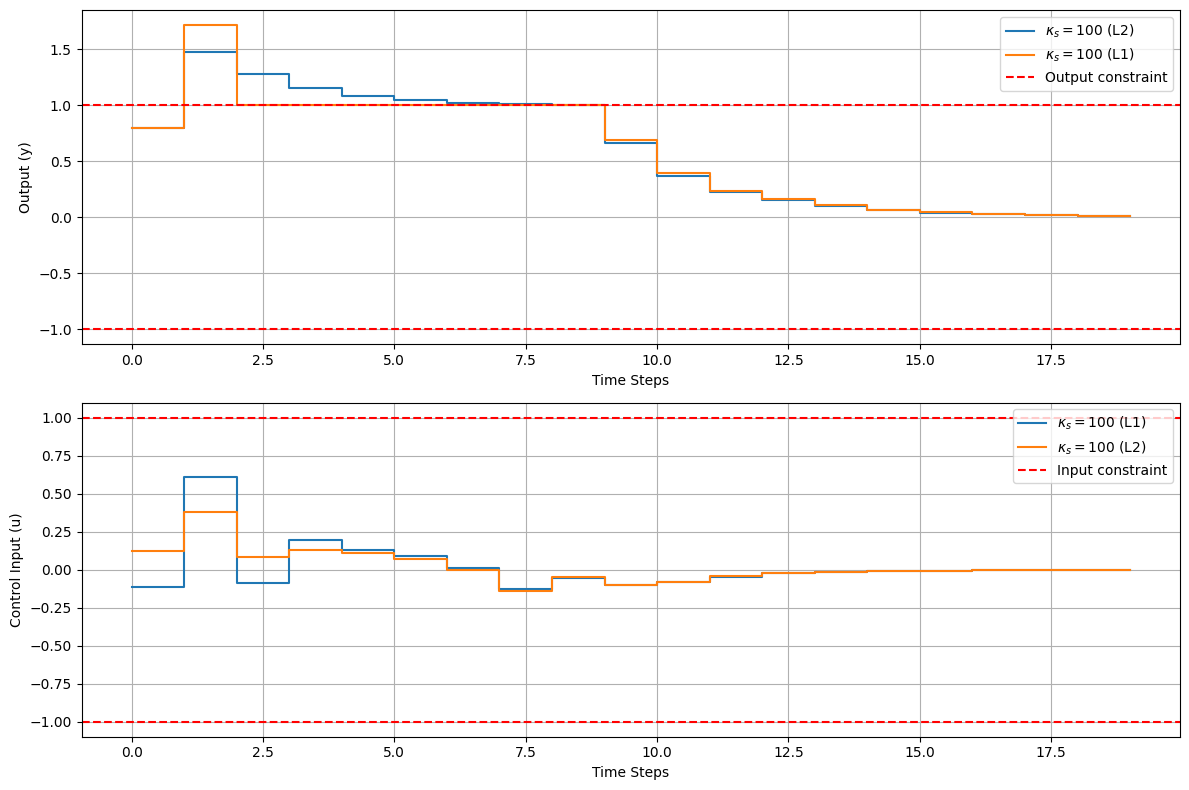

In [3]:


# Define the cost matrices
Q = C.T @ C  # Q = C^T C
R = np.array([[1]])
T = 20  # Prediction horizon

# Create the MPC parameters object
mpc_params = MPCParameters(system=sys_disc, horizon=T, Q=Q, R=R)

# Add input constraint (magnitude less than 1)
mpc_params.add_input_magnitude_constraint(limit=1)

# Add output magnitude constraint with softening
mpc_params.add_output_magnitude_constraint(limit=1, is_hard=False, penalty_weight=100)  # Linear slack penalty

# Add terminal ingredients (skipped as per the example)
# We are skipping terminal constraints and costs in this example

# Create the MPC object with linear slack penalties (L1)
mpc_params.slack_penalty = 'LINEAR'  # Linear penalties on slack
mpc = MPC(mpc_params)

# Simulation settings
T_sim = 20  # Number of simulation steps
x0 = np.array([0.8, 0.8, 0.8])  # Initial state
x_sim = np.zeros((3, T_sim + 1))  # Store state trajectory
u_sim = np.zeros(T_sim)  # Store control inputs
y_sim = np.zeros(T_sim)  # Store outputs
x_sim[:, 0] = x0  # Set initial state

# Simulation loop for linear slack penalty
for t in range(T_sim):
    # Get the current state
    current_state = x_sim[:, t]

    # Compute the control action using MPC
    u_t = mpc.get_control_action(current_state)
    u_sim[t] = u_t  # Store the control input

    # Apply the control input to the discrete-time system
    x_next = A @ current_state + B @ np.array([u_t]).flatten()
    x_sim[:, t + 1] = x_next

    # Compute the output
    y_sim[t] = C @ current_state

# Repeat simulation with quadratic slack penalty (L2)
mpc_params.slack_penalty = 'SQUARE'  # Quadratic penalties on slack
mpc = MPC(mpc_params)
x_sim_l2 = np.zeros((3, T_sim + 1))
u_sim_l2 = np.zeros(T_sim)
y_sim_l2 = np.zeros(T_sim)
x_sim_l2[:, 0] = x0

for t in range(T_sim):
    current_state = x_sim_l2[:, t]
    u_t = mpc.get_control_action(current_state)
    u_sim_l2[t] = u_t
    x_next = A @ current_state + B @ np.array([u_t]).flatten()
    x_sim_l2[:, t + 1] = x_next
    y_sim_l2[t] = C @ current_state

# Plotting the results
time = np.arange(T_sim)

plt.figure(figsize=(12, 8))

# Plot output y
plt.subplot(2, 1, 1)
plt.step(time, y_sim_l2, where='post', label=r'$\kappa_s=100$ (L2)')
plt.step(time, y_sim, where='post', label=r'$\kappa_s=100$ (L1)')
plt.axhline(1, color='r', linestyle='--', label='Output constraint')
plt.axhline(-1, color='r', linestyle='--')
plt.xlabel('Time Steps')
plt.ylabel('Output (y)')
plt.legend()
plt.grid()

# Plot control input u
plt.subplot(2, 1, 2)
plt.step(time, u_sim, where='post', label=r'$\kappa_s=100$ (L1)')
plt.step(time, u_sim_l2, where='post', label=r'$\kappa_s=100$ (L2)')
plt.axhline(1, color='r', linestyle='--', label='Input constraint')
plt.axhline(-1, color='r', linestyle='--')
plt.xlabel('Time Steps')
plt.ylabel('Control Input (u)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
